<h2 id="Contents">Contents<a href="#Contents"></a></h2>
        <ol>
<li><a class="" href="#Imports">Imports</a></li>
<li><a class="" href="#Loading-Data">Loading Data</a></li>
<ol><li><a class="" href="#Getting-X-and-y">Getting X and y</a></li>
<li><a class="" href="#Getting-Train-and-Test-Datasets">Getting Train and Test Datasets</a></li>
<li><a class="" href="#Converting-the-Array-to-Tensorflow-Dataset">Converting the Array to Tensorflow Dataset</a></li>
</ol><li><a class="" href="#Modeling">Modeling</a></li>
<ol><li><a class="" href="#Creating-Callbacks">Creating Callbacks</a></li>
<li><a class="" href="#Base-Model">Base Model</a></li>
<li><a class="" href="#Model_1">Model_1</a></li>
<li><a class="" href="#Model-2">Model 2</a></li>
<li><a class="" href="#Final-Model">Final Model</a></li>
<li><a class="" href="#Making-Submission-File">Making Submission File</a></li>
</ol>

# Imports

In [12]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.layers as tfl
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [13]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

## Getting X and y

In [14]:
X = df.iloc[:, 1:].values
y = df.iloc[:,0].values

In [15]:
test_data = test_df.values
test_data.shape

(28000, 784)

## Getting Train and Test Datasets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

We'll normalize the data:

In [17]:
X_train=X_train/255.
X_test = X_test/255.
test_data = test_data/255.

In [18]:
X_train.max(), X_test.max(), test_data.max()

(1.0, 1.0, 1.0)

## Converting the Array to Tensorflow Dataset

In [19]:
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train)
y_train_ds = tf.one_hot(y_train, depth=10)
y_train_ds = tf.data.Dataset.from_tensor_slices(y_train_ds)

X_test_ds = tf.data.Dataset.from_tensor_slices(X_test)
y_test_ds = tf.one_hot(y_test, depth=10)
y_test_ds = tf.data.Dataset.from_tensor_slices(y_test_ds)

train_ds = tf.data.Dataset.zip((X_train_ds, y_train_ds))
test_ds = tf.data.Dataset.zip((X_test_ds, y_test_ds))

test_data_ds = tf.data.Dataset.from_tensor_slices(test_data)

2022-10-11 09:49:18.664541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 09:49:18.754715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 09:49:18.755493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 09:49:18.759116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
batch_size = 64
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data_ds = test_data_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [21]:
for data, label in train_ds.take(1):
    input_shape = data[0].shape
    output_shape = label[0].shape
    print(data[0].shape)
    print(label[0].shape)

(784,)
(10,)


Excellent!

# Modeling

## Creating Callbacks

We'll be creating two callbacks:
1. `ModelCheckpoint`: This will save the weights of the best model which can be loaded later.
2. `EarlyStopping`: This callback will stop the training if the performance is not improving.

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
def model_checkpoint(name, directory="MNIST"):
    dir = os.path.join(directory, name)
    mch = ModelCheckpoint(
        dir, monitor='val_accuracy', verbose=1, save_best_only=True,
        save_weights_only=False, mode='auto', save_freq='epoch',
    )
    return mch

est = EarlyStopping(
    monitor="val_loss",
    verbose=1,
    restore_best_weights=True,
)

## Base Model

We'll start with a base NN model (We already had a base ML model and even that was performing great). The base model here will be a simple feed forward network.

In [64]:
inputs = tfl.Input(shape= input_shape, name="input")
x = tfl.Dense(128, name="dense_1", activation="relu")(inputs)
outputs = tfl.Dense(10, activation="softmax", name="output")(x)

model_0 = Model(inputs=inputs, outputs=outputs, name="base_model")

model_0.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [65]:
model_0.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

In [66]:
EPOCHS = 10
history = model_0.fit(
    train_ds,
    validation_data=test_ds,
#     steps_per_epoch=len(train_ds),
#     validation_steps=len(test_data),
    epochs=EPOCHS,
    callbacks=[model_checkpoint("model_0")],
)

Epoch 1/10
591/591 [==============================] - 2s 3ms/step - loss: 0.3512 - accuracy: 0.9022 - val_loss: 0.2301 - val_accuracy: 0.9302

Epoch 00001: val_accuracy improved from -inf to 0.93024, saving model to MNIST/model_0
Epoch 2/10
591/591 [==============================] - 2s 3ms/step - loss: 0.1642 - accuracy: 0.9536 - val_loss: 0.1706 - val_accuracy: 0.9490

Epoch 00002: val_accuracy improved from 0.93024 to 0.94905, saving model to MNIST/model_0
Epoch 3/10
591/591 [==============================] - 1s 2ms/step - loss: 0.1150 - accuracy: 0.9679 - val_loss: 0.1438 - val_accuracy: 0.9562

Epoch 00003: val_accuracy improved from 0.94905 to 0.95619, saving model to MNIST/model_0
Epoch 4/10
591/591 [==============================] - 1s 3ms/step - loss: 0.0868 - accuracy: 0.9759 - val_loss: 0.1252 - val_accuracy: 0.9614

Epoch 00004: val_accuracy improved from 0.95619 to 0.96143, saving model to MNIST/model_0
Epoch 5/10
591/591 [==============================] - 1s 3ms/step - los

In [67]:
model_0.evaluate(test_ds), model_0.evaluate(train_ds)

591/591 [==============================] - 2s 2ms/step - loss: 0.0212 - accuracy: 0.9942


([0.1024898812174797, 0.9711904525756836],
 [0.021169116720557213, 0.9941534399986267])

We see that even this simple a model performs excellent.

## Model_1

This will be a shallow CNN. We'll reshape the one column data into $28\times 28\times 1$ so that a CNN can work on it.

In [68]:
inputs = tfl.Input(shape= input_shape, name="input")
x = tfl.Reshape((28, 28, 1), name="reshape")(inputs)
x = tfl.Conv2D(32, 5, name="conv_1")(x)
x = tfl.Conv2D(64, 5, name="conv_2")(x)
x = tfl.GlobalAveragePooling2D(name="global_avg_pooling")(x)
x = tfl.Dense(64, activation="relu")(x)
outputs = tfl.Dense(10, activation="softmax", name="output")(x)
model_1 = Model(inputs=inputs, outputs=outputs, name="simple_conv_model")

model_1.summary()

Model: "simple_conv_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv_2 (Conv2D)              (None, 20, 20, 64)        51264     
_________________________________________________________________
global_avg_pooling (GlobalAv (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 10)          

In [69]:
EPOCHS = 10
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)


history_1 = model_1.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
#     callbacks=[model_checkpoint(model_1.name)],
)

Epoch 1/10


2022-10-11 08:50:10.760178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


591/591 [==============================] - 9s 4ms/step - loss: 1.4497 - accuracy: 0.4900 - val_loss: 1.1995 - val_accuracy: 0.5602
Epoch 2/10
591/591 [==============================] - 2s 4ms/step - loss: 1.0503 - accuracy: 0.6390 - val_loss: 1.0243 - val_accuracy: 0.6367
Epoch 3/10
591/591 [==============================] - 3s 4ms/step - loss: 0.9334 - accuracy: 0.6823 - val_loss: 0.9324 - val_accuracy: 0.6702
Epoch 4/10
591/591 [==============================] - 3s 4ms/step - loss: 0.8748 - accuracy: 0.7035 - val_loss: 0.8548 - val_accuracy: 0.7088
Epoch 5/10
591/591 [==============================] - 2s 4ms/step - loss: 0.8249 - accuracy: 0.7228 - val_loss: 0.7935 - val_accuracy: 0.7388
Epoch 6/10
591/591 [==============================] - 3s 4ms/step - loss: 0.7815 - accuracy: 0.7372 - val_loss: 0.7580 - val_accuracy: 0.7533
Epoch 7/10
591/591 [==============================] - 2s 4ms/step - loss: 0.7461 - accuracy: 0.7477 - val_loss: 0.7328 - val_accuracy: 0.7564
Epoch 8/10
591/59

In [23]:
model_1.evaluate(test_ds), model_1.evaluate(train_ds)

66/66 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.7752

591/591 [==============================] - 2s 3ms/step - loss: 0.6592 - accuracy: 0.7747


([0.6770902276039124, 0.7752380967140198],
 [0.6592001914978027, 0.7746560573577881])

It seems we need to go deeper. This will be our next model. But before that let's try the same model as `model_1` but `GlobalAveragePooling2D` replaced with `GlobalMaxPooling2D`.

In [70]:
inputs = tfl.Input(shape= input_shape, name="input")
x = tfl.Reshape((28, 28, 1), name="reshape")(inputs)
x = tfl.Conv2D(32, 5, name="conv_1")(x)
x = tfl.Conv2D(64, 5, name="conv_2")(x)
x = tfl.GlobalMaxPooling2D(name="global_avg_pooling")(x)
x = tfl.Dense(64, activation="relu")(x)
outputs = tfl.Dense(10, activation="softmax", name="output")(x)
model_1 = Model(inputs=inputs, outputs=outputs, name="simple_conv_model")


EPOCHS = 10
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

history_1 = model_1.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
#     callbacks=[model_checkpoint(model_1.name)],
)

Epoch 1/10
591/591 [==============================] - 3s 4ms/step - loss: 0.4308 - accuracy: 0.8770 - val_loss: 0.1298 - val_accuracy: 0.9607
Epoch 2/10
591/591 [==============================] - 2s 4ms/step - loss: 0.1322 - accuracy: 0.9583 - val_loss: 0.1099 - val_accuracy: 0.9679
Epoch 3/10
591/591 [==============================] - 2s 4ms/step - loss: 0.1067 - accuracy: 0.9672 - val_loss: 0.1012 - val_accuracy: 0.9690
Epoch 4/10
591/591 [==============================] - 3s 4ms/step - loss: 0.0924 - accuracy: 0.9706 - val_loss: 0.0912 - val_accuracy: 0.9729
Epoch 5/10
591/591 [==============================] - 2s 4ms/step - loss: 0.0811 - accuracy: 0.9749 - val_loss: 0.0758 - val_accuracy: 0.9762
Epoch 6/10
591/591 [==============================] - 2s 4ms/step - loss: 0.0739 - accuracy: 0.9774 - val_loss: 0.0716 - val_accuracy: 0.9760
Epoch 7/10
591/591 [==============================] - 3s 4ms/step - loss: 0.0682 - accuracy: 0.9784 - val_loss: 0.0696 - val_accuracy: 0.9786
Epoch 

In [71]:
model_1.evaluate(test_ds), model_1.evaluate(train_ds)

591/591 [==============================] - 2s 3ms/step - loss: 0.0392 - accuracy: 0.9869


([0.06705280393362045, 0.9807142615318298],
 [0.03919436037540436, 0.9869312047958374])

Oh-ho! Just one change is resulting in a massive improvement. Well, it seems that from now one we should use be using `GlobalMaxPooling2D` instead of `GlobalAveragePooling2D`.

## Model 2

In [87]:
inputs = tfl.Input(shape= input_shape, name="input")
x = tfl.Reshape((28, 28, 1), name="reshape")(inputs)
x = tfl.Conv2D(32, 3, name="conv_11", activation='relu')(x)
x = tfl.Conv2D(64, 3, name="conv_12", activation='relu')(x)
x = tfl.MaxPool2D(pool_size=(2, 2), name="maxpool_1")(x)
x = tfl.BatchNormalization(axis=-1, name="batchnorm_1")(x)

x = tfl.Conv2D(128, 3, name="conv_21", activation='relu')(x)
x = tfl.Conv2D(256, 3, name="conv_22", activation='relu')(x)
x = tfl.MaxPool2D(pool_size=(2, 2), name="maxpool_2")(x)
x = tfl.Dropout(0.25, name="dropout_21")(x)
x = tfl.BatchNormalization(axis=-1, name="batchnorm_2")(x)

x = tfl.Conv2D(512, 2, name="conv_31", activation='relu')(x)
x = tfl.Conv2D(1024, 2, name="conv_32", activation='relu')(x)


x = tfl.GlobalMaxPooling2D(name="global_avg_pooling")(x)
x = tfl.Dense(128, activation="relu", name="dense_1")(x)
x = tfl.Dropout(0.25, name="dropout_1")(x)
x = tfl.Dense(256, activation="relu", name="dense_2")(x)
x = tfl.Dropout(0.4, name="dropout_2")(x)
outputs = tfl.Dense(10, activation="softmax", name="output")(x)
model_2 = Model(inputs=inputs, outputs=outputs, name="deep_conv_model")

model_2.summary()

Model: "deep_conv_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_11 (Conv2D)             (None, 26, 26, 32)        320       
_________________________________________________________________
conv_12 (Conv2D)             (None, 24, 24, 64)        18496     
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 12, 12, 64)        0         
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 12, 12, 64)        256       
_________________________________________________________________
conv_21 (Conv2D)             (None, 10, 10, 128)   

In [88]:
EPOCHS = 10
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)


history_2 = model_2.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
#     callbacks=[model_checkpoint(model_2.name)],
)

Epoch 1/10
591/591 [==============================] - 7s 10ms/step - loss: 0.3001 - accuracy: 0.9069 - val_loss: 0.1673 - val_accuracy: 0.9617
Epoch 2/10
591/591 [==============================] - 6s 10ms/step - loss: 0.0913 - accuracy: 0.9777 - val_loss: 0.0562 - val_accuracy: 0.9881
Epoch 3/10
591/591 [==============================] - 6s 10ms/step - loss: 0.0668 - accuracy: 0.9840 - val_loss: 0.0484 - val_accuracy: 0.9857
Epoch 4/10
591/591 [==============================] - 6s 10ms/step - loss: 0.0546 - accuracy: 0.9867 - val_loss: 0.0361 - val_accuracy: 0.9888
Epoch 5/10
591/591 [==============================] - 6s 10ms/step - loss: 0.0464 - accuracy: 0.9884 - val_loss: 0.0467 - val_accuracy: 0.9869
Epoch 6/10
591/591 [==============================] - 6s 10ms/step - loss: 0.0401 - accuracy: 0.9907 - val_loss: 0.0374 - val_accuracy: 0.9900
Epoch 7/10
591/591 [==============================] - 6s 10ms/step - loss: 0.0376 - accuracy: 0.9903 - val_loss: 0.0566 - val_accuracy: 0.9871

Let's train for some more epochs.

In [89]:
EPOCHS = 15

history_2 = model_2.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint(model_2.name)],
)

Epoch 1/15
591/591 [==============================] - 6s 10ms/step - loss: 0.0309 - accuracy: 0.9928 - val_loss: 0.0568 - val_accuracy: 0.9893
Epoch 2/15
591/591 [==============================] - 6s 10ms/step - loss: 0.0280 - accuracy: 0.9934 - val_loss: 0.0406 - val_accuracy: 0.9905
Epoch 3/15
591/591 [==============================] - 6s 10ms/step - loss: 0.0303 - accuracy: 0.9929 - val_loss: 0.0367 - val_accuracy: 0.9924
Epoch 4/15
591/591 [==============================] - 6s 10ms/step - loss: 0.0317 - accuracy: 0.9936 - val_loss: 0.0586 - val_accuracy: 0.9881
Epoch 5/15
591/591 [==============================] - 6s 10ms/step - loss: 0.0224 - accuracy: 0.9949 - val_loss: 0.0458 - val_accuracy: 0.9905
Epoch 6/15
591/591 [==============================] - 6s 10ms/step - loss: 0.0226 - accuracy: 0.9949 - val_loss: 0.0496 - val_accuracy: 0.9893
Epoch 7/15
591/591 [==============================] - 6s 10ms/step - loss: 0.0258 - accuracy: 0.9945 - val_loss: 0.0593 - val_accuracy: 0.9921

In [90]:
model_2.evaluate(test_ds), model_2.evaluate(train_ds)

591/591 [==============================] - 3s 4ms/step - loss: 0.0052 - accuracy: 0.9987


([0.05566512793302536, 0.9930952191352844],
 [0.005172932054847479, 0.9986772537231445])

In [91]:
y_pred = model_2.predict(test_data_ds)
y_pred = np.argmax(y_pred, axis = -1)
submission = pd.DataFrame({'ImageId': range(1, test_data.shape[0]+1), 'Label': y_pred})
submission.groupby('Label').count()

,ImageId
Label,
0,2774
1,3211
2,2839
3,2774
4,2755
5,2488
6,2755
7,2897
8,2724


In [92]:
y_pred

array([2, 0, 9, ..., 3, 9, 2])

## Final Model

In [31]:
model_3 = Sequential(name="final_model")
model_3.add(tfl.Reshape((28, 28, 1), name="reshape", input_shape=input_shape))
model_3.add(tfl.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1),
             padding='same')),
model_3.add(tfl.Conv2D(32, kernel_size=(3, 3), activation='relu',
                padding='same')),
model_3.add(tfl.AveragePooling2D(pool_size=(2, 2)))
model_3.add(tfl.BatchNormalization())
model_3.add(tfl.Dropout(0.3))
model_3.add(tfl.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(tfl.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(tfl.AveragePooling2D(pool_size=(2, 2)))
model_3.add(tfl.BatchNormalization())
model_3.add(tfl.Dropout(0.3))
model_3.add(tfl.Conv2D(128, kernel_size=(3, 3), activation='relu' , padding='same', kernel_regularizer = tf.keras.regularizers.l1(0.01)))
model_3.add(tfl.Conv2D(128, kernel_size=(3, 3), activation='relu' , padding='same', kernel_regularizer = tf.keras.regularizers.l1(0.01)))
model_3.add(tfl.AveragePooling2D(pool_size=(2, 2)))
model_3.add(tfl.BatchNormalization())

model_3.add(tfl.Flatten())
model_3.add(tfl.Dropout(0.35))
model_3.add(tfl.Dense(128, activation='relu'))
model_3.add(tfl.BatchNormalization())
model_3.add(tfl.Dense(10, activation='softmax'))

model_3.compile(optimizer='adam', loss='categorical_crossentropy', 
    metrics=['accuracy'])

model_3.summary()

Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
average_pooling2d_6 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        

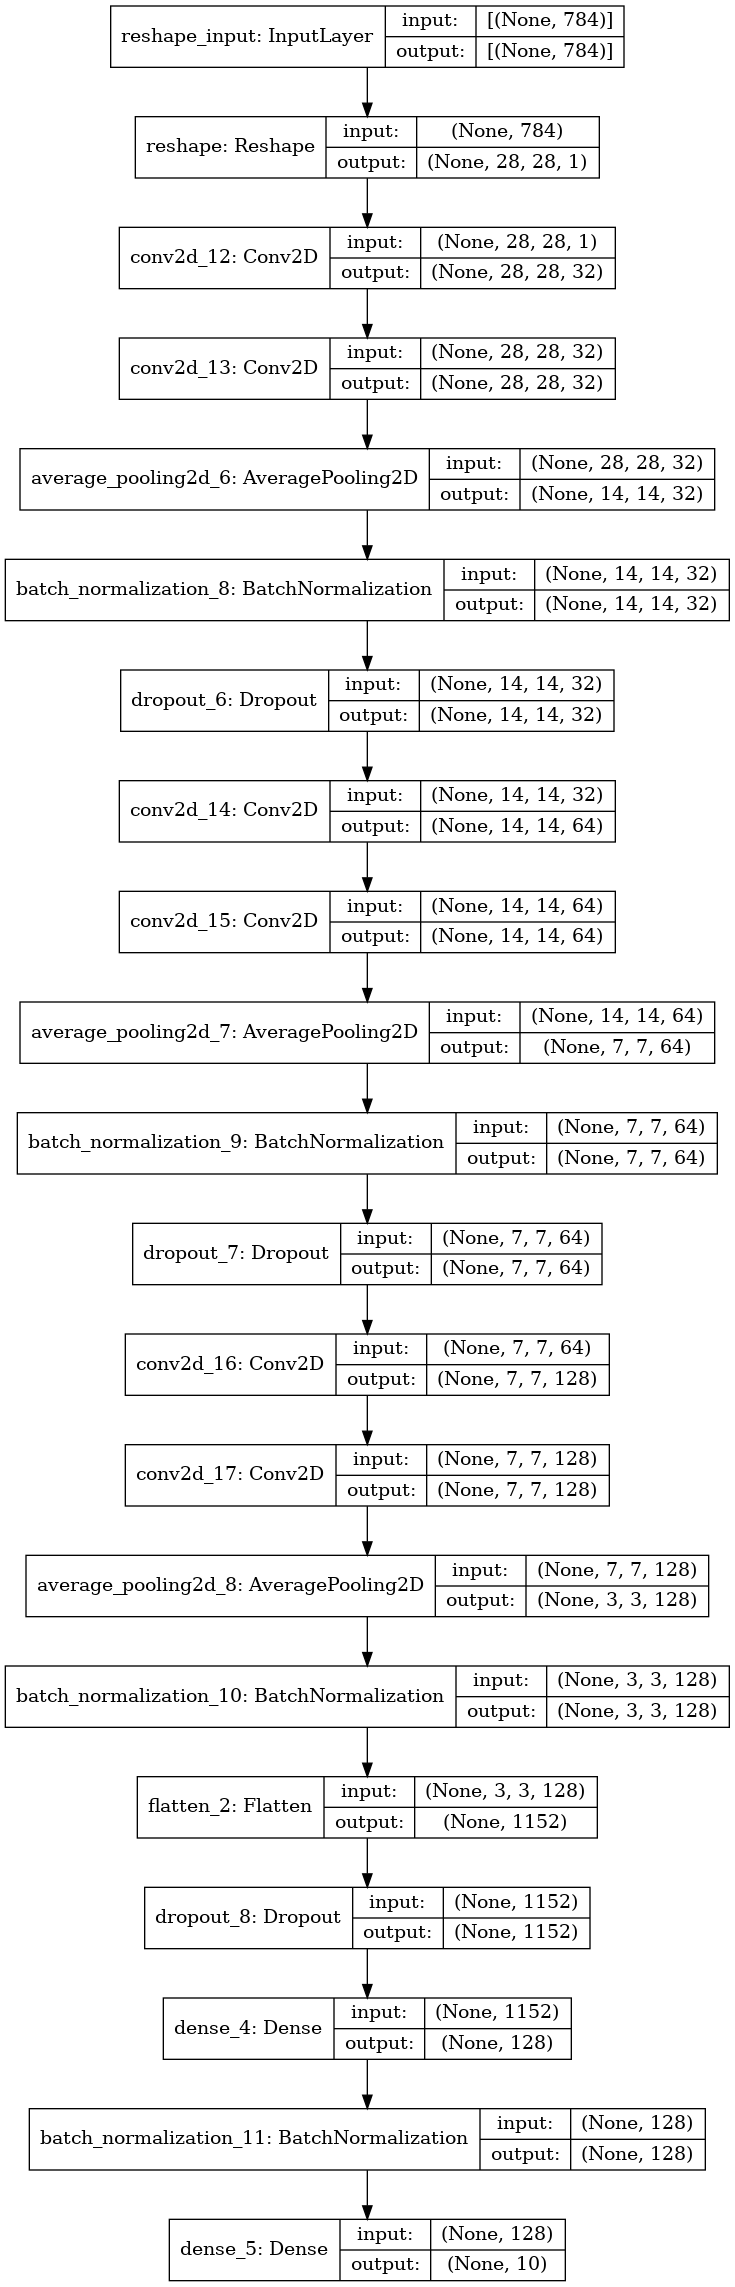

In [32]:
tf.keras.utils.plot_model(model_3, show_shapes=True,dpi=96)

In [33]:
history_3_1 = model_3.fit(train_ds, epochs=100, validation_data=test_ds,
#         callbacks=[model_checkpoint(model_3.name)]
                      )

Epoch 1/100
591/591 [==============================] - 5s 7ms/step - loss: 4.4422 - accuracy: 0.9371 - val_loss: 0.8674 - val_accuracy: 0.8969
Epoch 2/100
591/591 [==============================] - 4s 7ms/step - loss: 0.5233 - accuracy: 0.9698 - val_loss: 0.4799 - val_accuracy: 0.9748
Epoch 3/100
591/591 [==============================] - 4s 6ms/step - loss: 0.5003 - accuracy: 0.9756 - val_loss: 0.4713 - val_accuracy: 0.9781
Epoch 4/100
591/591 [==============================] - 4s 7ms/step - loss: 0.4833 - accuracy: 0.9778 - val_loss: 0.4532 - val_accuracy: 0.9755
Epoch 5/100
591/591 [==============================] - 4s 6ms/step - loss: 0.4748 - accuracy: 0.9788 - val_loss: 0.4521 - val_accuracy: 0.9817
Epoch 6/100
591/591 [==============================] - 4s 7ms/step - loss: 0.4545 - accuracy: 0.9805 - val_loss: 0.4192 - val_accuracy: 0.9836
Epoch 7/100
591/591 [==============================] - 4s 6ms/step - loss: 0.4572 - accuracy: 0.9819 - val_loss: 0.4148 - val_accuracy: 0.9860

In [34]:
history_3_2 = model_3.fit(train_ds, epochs=300, validation_data=test_ds, initial_epoch = 100,
        callbacks=[model_checkpoint(model_3.name)]
                      )

Epoch 101/300
591/591 [==============================] - 4s 7ms/step - loss: 0.3173 - accuracy: 0.9943 - val_loss: 0.3273 - val_accuracy: 0.9936

Epoch 00101: val_accuracy improved from -inf to 0.99357, saving model to MNIST/final_model
Epoch 102/300
591/591 [==============================] - 4s 7ms/step - loss: 0.3243 - accuracy: 0.9945 - val_loss: 0.3342 - val_accuracy: 0.9881

Epoch 00102: val_accuracy did not improve from 0.99357
Epoch 103/300
591/591 [==============================] - 4s 6ms/step - loss: 0.3190 - accuracy: 0.9943 - val_loss: 0.3419 - val_accuracy: 0.9898

Epoch 00103: val_accuracy did not improve from 0.99357
Epoch 104/300
591/591 [==============================] - 4s 6ms/step - loss: 0.3150 - accuracy: 0.9947 - val_loss: 0.3079 - val_accuracy: 0.9938

Epoch 00104: val_accuracy improved from 0.99357 to 0.99381, saving model to MNIST/final_model
Epoch 105/300
591/591 [==============================] - 4s 7ms/step - loss: 0.3155 - accuracy: 0.9944 - val_loss: 0.3275

In [35]:
best_model = tf.keras.models.load_model("MNIST/final_model")

In [36]:
model_3.evaluate(test_ds), model_3.evaluate(train_ds)

591/591 [==============================] - 2s 3ms/step - loss: 0.2850 - accuracy: 0.9991


([0.3149450421333313, 0.9909523725509644],
 [0.28497061133384705, 0.9991005063056946])

In [37]:
best_model.evaluate(test_ds), best_model.evaluate(train_ds)

591/591 [==============================] - 2s 3ms/step - loss: 0.2744 - accuracy: 0.9996


([0.29607927799224854, 0.9957143068313599],
 [0.27441176772117615, 0.9996031522750854])

## Making Submission File

In [39]:
y_pred = model_3.predict(test_data_ds)
y_pred = np.argmax(y_pred, axis = -1)
submission = pd.DataFrame({'ImageId': range(1, test_data.shape[0]+1), 'Label': y_pred})
submission.groupby('Label').count()

,ImageId
Label,
0,2755
1,3185
2,2802
3,2831
4,2763
5,2519
6,2734
7,2897
8,2754


In [40]:
submission.to_csv("submission.csv", index = False)

In [41]:
from IPython.display import FileLink
FileLink("submission.csv")

/kaggle/working/submission.csv